### Import Libraries

In [1]:
%matplotlib inline
import os

import cv2
import numpy as np
import json

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics.classification import Dice
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, faster_rcnn, maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.classification import BinaryConfusionMatrix
from torchvision.datasets import CocoDetection

from utilities import AITEXPatchedSegmentation

c:\compute\envs\fdd\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\compute\envs\fdd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define paths
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_dir = os.path.join(root, "models")
data_dir = os.path.join(root, "data")
aitex_dir = os.path.join(data_dir, "aitex")
od_dir = os.path.join(aitex_dir, "object_detection")
img_dir = os.path.join(od_dir, "images")
mask_dir = os.path.join(od_dir, "masks")

In [3]:
class COCO_AITEX(Dataset):
    """Builds OD dataset in memory for AITEX fabric defects."""
    def __init__(self, img_dir, mask_dir, anno_path):
        """Read images."""
        self.img_dir = img_dir
        self.anno_path = anno_path

        with open(os.path.join(od_dir, "annotations.json"), "r") as anno_file:
            self.annotations = json.load(anno_file)
        
        self.images = [cv2.imread(os.path.join(img_dir, x["file_name"])) for x in self.annotations["images"]]
        self.images = [torch.Tensor(x.reshape((3, 256, 256))) / 255. for x in self.images]
        self.masks = [cv2.imread(os.path.join(mask_dir, x["file_name"])) for x in self.annotations["images"]]
        self.masks = [torch.Tensor(x.reshape((3, 256, 256))) / 255. for x in self.masks]
        self.targets = []
        for anno in self.annotations["annotations"]:
            self.targets.append({
                "boxes": torch.Tensor([anno["bbox"]]),
                "labels": torch.Tensor([anno["category_id"]]).type(torch.int64)
                })
    def __len__(self):
        """Get length of full dataset."""
        return len(self.images)
    
    def __getitem__(self, idx):
        """Return specific index of dataset."""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.images[idx], self.masks[idx], self.targets[idx]

data = COCO_AITEX(img_dir, mask_dir, os.path.join(od_dir, "annotations.json"))
data_loader = DataLoader(data, batch_size=2, shuffle=True)
    

In [4]:
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])
# data = CocoDetection(img_dir, os.path.join(od_dir, "annotations.json"), transform=transform)
# data_loader = DataLoader(data, batch_size=2, shuffle=True)


### Mask Approach

In [5]:
device = "cuda"

model = maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=13)
model.to(device)

c:\compute\envs\fdd\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\compute\envs\fdd\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [36]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

num_epochs = 10
for i in range(num_epochs):
    loss_list = []
    for img, mask, target in data:
        x = [img.to(device)]
        y = {}
        y["boxes"] = target["boxes"].to(device)
        y["labels"] = target["labels"].to(device)
        y["masks"] = mask.to(device)

        optimizer.zero_grad()
        loss_dict = model(x, [y])

        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        loss_list.append(losses.item())
    print(i,'loss:', np.mean(loss_list))

0 loss: 0.24459041731583106
1 loss: 0.24026691478651924
2 loss: 0.2544151755804951
3 loss: 0.2202130998812012
4 loss: 0.20452085294433542
5 loss: 0.22017322379995036
6 loss: 0.21497109795140254
7 loss: 0.20164429180928178
8 loss: 0.18759996512451688
9 loss: 0.17694245685596724


In [37]:
model.eval()
img, mask, target = data[141]
x = [img.to(device)]
pred = model(x)

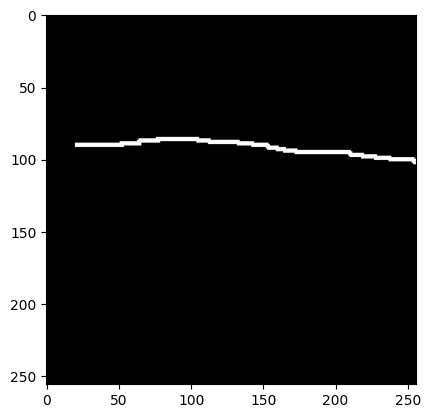

In [38]:
plt.imshow(mask.reshape((256, 256, 3)))

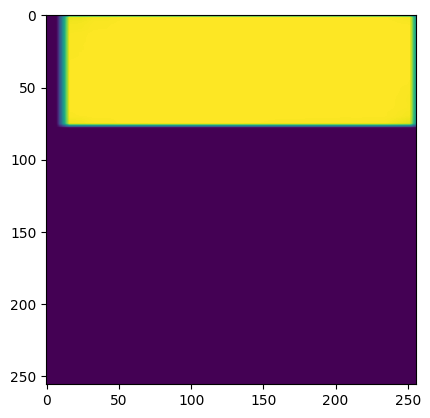

In [39]:
plt.imshow(pred[0]['masks'][0].reshape((256, 256)).cpu().detach())

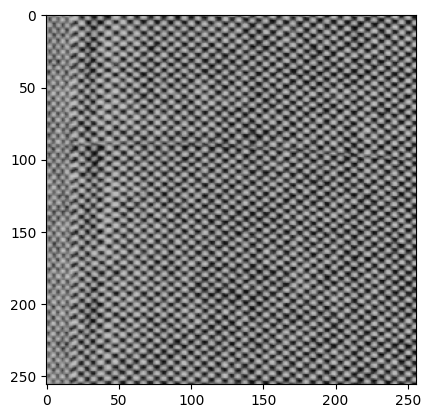

In [40]:
plt.imshow(img.reshape((256, 256, 3)))

### RCNN OD

In [5]:
device = "cuda"

model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 13
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.to(device)

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for img, target in data:
        x = [img.to(device)]
        y =  [{k: torch.Tensor([v]).to(device) for k, v in t.items()} for t in target]
        y = {}
        y["boxes"] = torch.Tensor(target[0]["bbox"]).reshape((1, 4)).to(device)
        y["labels"] = torch.Tensor([target[0]["category_id"]]).type(torch.int64).to(device)
        
        loss_dict = model(x, [y])
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {losses.item()}")
    break


c:\compute\envs\fdd\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\compute\envs\fdd\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10, Loss: nan


In [8]:
x

[tensor([[[0.1686, 0.1216, 0.1216,  ..., 0.1216, 0.1686, 0.3765],
          [0.0902, 0.0549, 0.1216,  ..., 0.0196, 0.0353, 0.1294],
          [0.2941, 0.1961, 0.2039,  ..., 0.1373, 0.1686, 0.2353],
          ...,
          [0.1961, 0.3569, 0.6235,  ..., 0.0745, 0.1059, 0.4549],
          [0.4118, 0.4118, 0.4863,  ..., 0.2353, 0.1961, 0.3843],
          [0.5765, 0.4549, 0.2863,  ..., 0.4941, 0.2941, 0.1216]],
 
         [[0.1686, 0.1216, 0.1216,  ..., 0.1216, 0.1686, 0.3765],
          [0.0902, 0.0549, 0.1216,  ..., 0.0196, 0.0353, 0.1294],
          [0.2941, 0.1961, 0.2039,  ..., 0.1373, 0.1686, 0.2353],
          ...,
          [0.1961, 0.3569, 0.6235,  ..., 0.0745, 0.1059, 0.4549],
          [0.4118, 0.4118, 0.4863,  ..., 0.2353, 0.1961, 0.3843],
          [0.5765, 0.4549, 0.2863,  ..., 0.4941, 0.2941, 0.1216]],
 
         [[0.1686, 0.1216, 0.1216,  ..., 0.1216, 0.1686, 0.3765],
          [0.0902, 0.0549, 0.1216,  ..., 0.0196, 0.0353, 0.1294],
          [0.2941, 0.1961, 0.2039,  ...,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


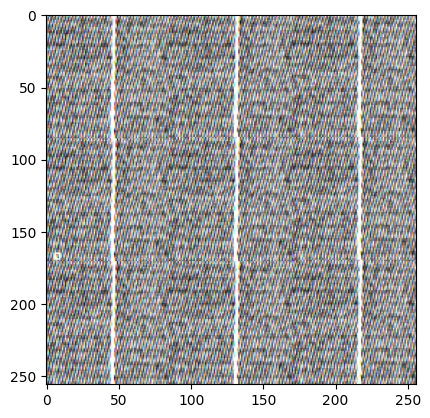

In [51]:
img, target = dataset[10]

ground_truth = img.reshape(256, 256, 3).numpy()
x1, y1, x2, y2 = target[0]['bbox']
ground_truth = cv2.rectangle(ground_truth,(x1, y1), (x2, y2),(255, 255, 255),1)

plt.imshow(ground_truth)

In [27]:
plt.imshow(x.reshape(256, 256, 3))

AttributeError: 'list' object has no attribute 'reshape'

In [28]:
model.eval()

res = model(x)

In [29]:
res

[{'boxes': tensor([[  5.9809, 164.9953,   8.9819, 168.9492],
          [  5.8806,  93.2721,   9.0058,  97.3250],
          [  5.9602,  52.1998,   9.0157,  56.4257],
          [  5.7049, 205.8129,   9.1752, 210.1864]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([8, 8, 8, 8], device='cuda:0'),
  'scores': tensor([0.9164, 0.8806, 0.1905, 0.0670], device='cuda:0',
         grad_fn=<IndexBackward0>)}]